# Simualtion of simple OTDR-trace

In [5]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Constants:

In [361]:
L = 1000 # fiber length, m
Ladc = 1 # sampling frequency of receiver, m
alpha = 0.0410517 # attenuation, 1/km
c = 300000000 # light speed, m/s
n0 = 1.5      # refractive index
lamda = 1550e-9 # wavelength, m
kv = 2*np.pi/lamda # wavenumber, 1/m  
w0 = kv * c # carrier frequency, Hz
n_metre = 1 # number rayleigh centres (RC) at 1 m

## 2. Graphical scalar model of fiber with random distrbution RC along Z-axis:
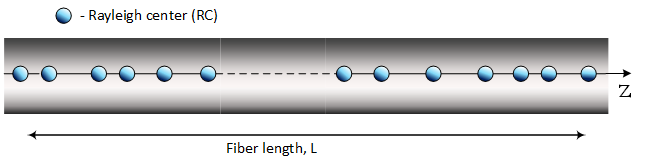

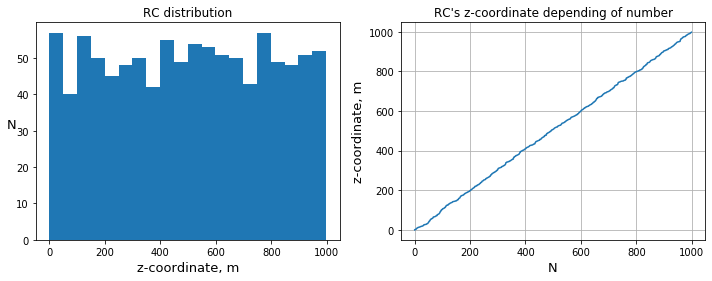

In [362]:
np.random.seed(1) # fixing random RC distribution
z_sc = np.sort(np.random.rand(int(n_metre*L)))*L # RC's coordinates along fiber

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('RC distribution')
plt.hist(z_sc, 20)
plt.ylabel('N', rotation=0, fontsize = 13)
plt.xlabel('z-coordinate, m', fontsize = 13)
plt.subplot(122)
plt.title('RC\'s z-coordinate depending of number')
plt.plot(z_sc)
plt.xlabel('N', fontsize = 13)
plt.ylabel('z-coordinate, m', fontsize = 13)
plt.grid()

## 3. Probe pulse 

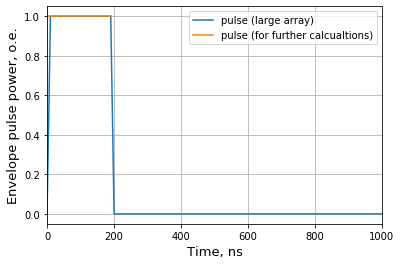

In [363]:
Ndots = int(L / Ladc) 
Time = 2 * L * n0 / c  # duration of backscattering signal, s
T = np.linspace(0, Time, Ndots) # time-window of backscattered signal, s
Distance = T*c/n0/2 # spatial-window of backscattered signal, s
tau = 200e-9 # Pulse duration, s
Timp = T[T <= tau]                        # time-window of probe pulse, s
H = np.heaviside(tau/2 - np.abs(Timp-tau/2),1) # probe pulse 
H_showcase = np.heaviside(tau/2 - np.abs(T-tau/2),0) # probe pulse_showcase (large array)

plt.plot(T*1e9, H_showcase, label='pulse (large array)')
plt.plot(Timp*1e9, H, label='pulse (for further calcualtions)')
plt.legend()
plt.ylabel('Envelope pulse power, o.e.', fontsize=13)
plt.xlabel('Time, ns', fontsize=13)
plt.xlim(0,tau*1e9*5)
plt.grid()

## 4. Forming backscattering signal $A(z)$:

### 4.1 Fisrt backscattering model:

#### 4.1.1 Backscattering signal graphical model:
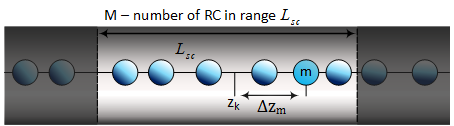

$L_{sc}$ - scattering length, that equals pulse length $\tau \frac{c}{2n}$.

$z_k$ - center of range $L_{sc}$

Sum of partial waves in the range $L_{sc}$:
$$A(z_k) = \sum_{m}^Me^{2ik\Delta z_m}$$  

#### 4.1.2 Simualtion backscattering signal

In [410]:
A1 = np.zeros(Ndots, dtype='complex64') #A(z) backscattering signal (complex amplitude) at reciver (z=0, t=n*2*z_k/c)

In [411]:
for k in range(Ndots):
    z_k = k*Ladc
    L_sc = z_sc[(z_sc<z_k+tau*c/n0/2) & (z_sc>z_k)]
    A1[z_k] = np.sum(np.exp(2j*kv*L_sc))

#### 4.1.3 Simualtion first method results

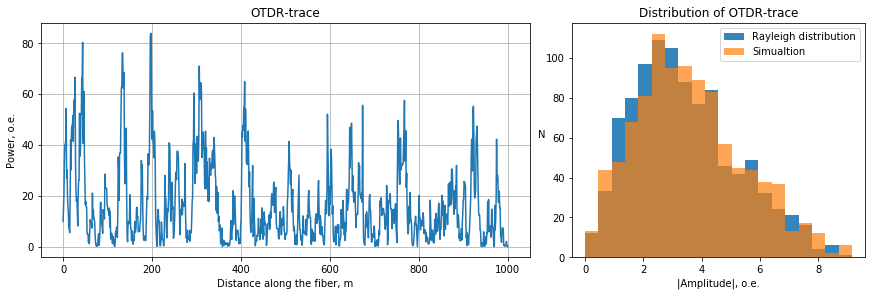

In [448]:
fig = plt.figure(constrained_layout=True, figsize=(12,4))
spec = fig.add_gridspec(ncols=8, nrows=1)
trace = np.abs(A1)**2
fig.add_subplot(spec[0, 0:5])
plt.plot(Distance, trace)
plt.title('OTDR-trace')
plt.ylabel('Power, o.e.')
plt.xlabel('Distance along the fiber, m')
plt.grid()

fig.add_subplot(spec[0, 5:])
np.random.seed(0)
ray_dist = np.random.rayleigh(scale=np.std(trace/2)**0.5, size=Ndots)
plt.hist(ray_dist, 20, alpha=0.9, range=(0,np.max(trace**0.5)), label='Rayleigh distribution')

plt.hist(trace**0.5, 20, range=(0,np.max(trace**0.5)), alpha=0.7, label='Simualtion')
plt.title('Distribution of OTDR-trace')
plt.ylabel('N', rotation=0)
plt.xlabel('|Amplitude|, o.e.')

plt.legend()
plt.show()

### 4.2 Second backscattering model:

#### 4.2.1 Backscattering signal graphical model:
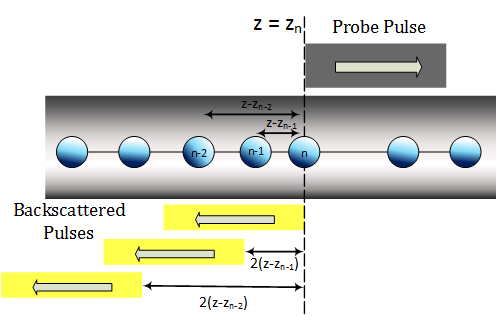

Sum of pulses backscattered at every RC:

$$A(z) = \sum_{n}^N H(2z-2z_n)\cdot e^{2ikz_n}$$  

#### 4.2.2 Simualtion backscattering signal

In [480]:
A2 = np.zeros(Ndots, dtype='complex64') #A(z) backscattering signal (complex amplitude) at reciver (z=0, t=n*2*z_k/c)

In [481]:
for z_n in z_sc:
    pulse_back = H * np.exp(2j * kv * z_n) # backscattered pulse at receiver (z=0)
    Zn = int(z_n / L * (Ndots) - len(Timp)) # it z-coordinate index in spatial-window "Distance" OTDR-trace
    
    if Zn < 0: 
        A2[0:Zn+len(Timp)] += pulse_back[:Zn+len(Timp)]
        
    elif Zn >= 0: # in case when part pulse behind of spatial-window
        A2[Zn:Zn+len(Timp)] += pulse_back[:]
        
    else: # in case when part pulse beyound of spatial-window
        A2[Zn:Ndots] += pulse_back[:Ndots - Zn] 

#### 4.2.3 Simualtion second method results

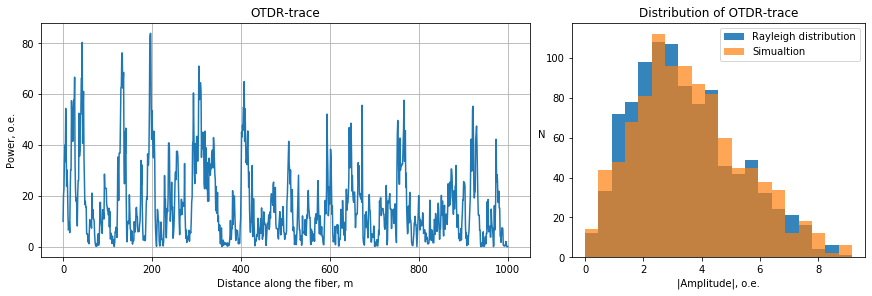

In [484]:
fig = plt.figure(constrained_layout=True, figsize=(12,4))
spec = fig.add_gridspec(ncols=8, nrows=1)
trace = np.abs(A2)**2
fig.add_subplot(spec[0, 0:5])
plt.plot(Distance, trace)
plt.title('OTDR-trace')
plt.ylabel('Power, o.e.')
plt.xlabel('Distance along the fiber, m')
plt.grid()

fig.add_subplot(spec[0, 5:])
np.random.seed(0)
ray_dist = np.random.rayleigh(scale=np.std(trace/2)**0.5, size=Ndots)
plt.hist(ray_dist, 20, alpha=0.9, range=(0,np.max(trace**0.5)), label='Rayleigh distribution')

plt.hist(trace**0.5, 20, range=(0,np.max(trace**0.5)), alpha=0.7, label='Simualtion')
plt.title('Distribution of OTDR-trace')
plt.ylabel('N', rotation=0)
plt.xlabel('|Amplitude|, o.e.')

plt.legend()
plt.show()

### 5. Both models show same results and in good agreement with Rayleigh distribution.